# Image Features Extraction

### A document object package for fast extraction of features from segmentable images 


# Introduction 



<img src="1.png">

## Features extraction for spatial Classification of nuclei

<img src="2b.png">

<img src="3.png">

## Collection objects and Iterators

<img src="4b.png">

# Tutorial

In [3]:
import image_features_extraction.Images as fe

    
collection_images = fe.Images('../images')


# the iterator at work ...
for img in collection_images:
    print(img.file_name())
    


../images/image_test1.tif
../images/image_test2.tif


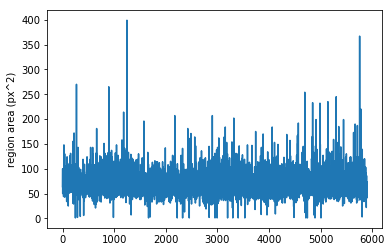

In [4]:
% matplotlib inline
import matplotlib.pyplot as plt


image = collection_images.item(0)


collection_regions = image.regions()


areas = collection_regions.prop_values('area')


plt.plot(areas)
plt.ylabel('region area (px^2)')

In [5]:
print('Num regions: {}'.format(collection_regions.count()))


df = collection_regions.get_features(['label', 'area','perimeter', 'centroid'], class_value=5)


df.head()


Num regions: 5900


,label,area,perimeter,centroid,class_name
0,22,64,28.278175,"(5.46875, 584.375)",5
1,23,86,33.556349,"(6.41860465116, 621.546511628)",5
2,24,100,35.556349,"(5.72, 1290.33)",5
3,25,50,24.142136,"(5.6, 23.04)",5
4,26,80,31.556349,"(7.325, 99.4625)",5


### Plot area vs perimeter and area histogram

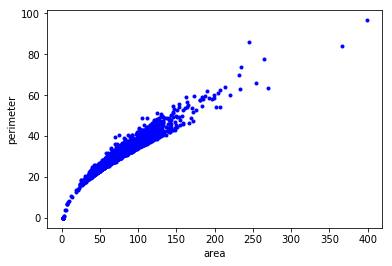

In [12]:

plt.plot(df.area, df.perimeter, '.b')
plt.xlabel('area')
plt.ylabel('perimeter')

(array([  22.,    5.,    2.,    1.,    2.,    7.,   16.,   35.,   63.,
         120.,  209.,  336.,  474.,  517.,  487.,  458.,  459.,  450.,
         419.,  366.,  301.,  252.,  180.,  144.,  116.,   92.,   63.,
          60.,   43.,   37.,   31.,   23.,   20.,   10.,    8.,   11.,
           9.,    5.,    5.,    4.,    4.,    2.,    4.,    2.,    0.,
           4.,    2.,    2.,    1.,    2.,    1.,    3.,    0.,    1.,
           0.,    1.,    0.,    0.,    3.,    0.,    0.,    1.,    0.,
           1.,    0.,    0.,    1.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([   1.  ,    4.98,    8.96,   12.94,   16.92,   20.9 ,   24.88,
          28.86,   32.84,   36.82,   40.8 ,   44.78,   48.76,   52.74,
          56.72,   60.7 ,   64.68,   68.66,   72.64,   76.62,   80.6

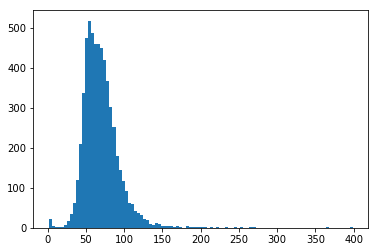

In [13]:
plt.hist(df.area,100)

### Show the region centroids

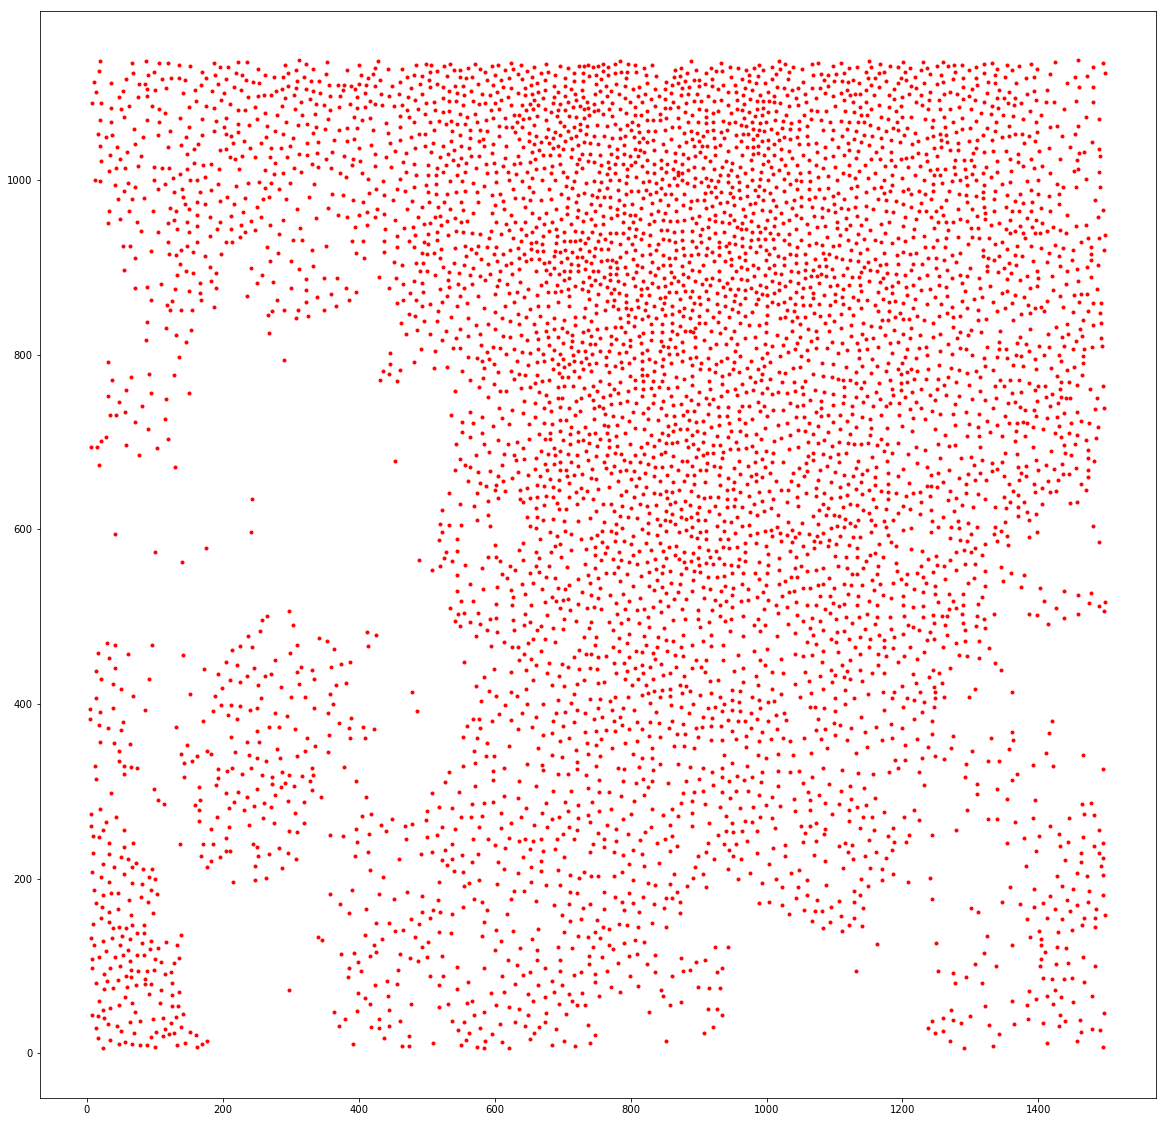

In [15]:

import numpy as np
a = np.array(df.centroid)
x=[]
y=[]
for i in a:
    x.append(i[0])
    y.append(i[1])

    
fig, axes = plt.subplots(figsize=(20, 20), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

plt.plot(y,x, '.r')

In [17]:

import scipy.misc as sm
from skimage.measure import label
from skimage import filters
from skimage.segmentation import clear_border
import os
import pandas as pd
from skimage.measure import label, regionprops


class MyException(Exception):
    pass

from abc import ABCMeta, abstractmethod


class my_iterator(object):
    """
    abstract class for the object iterator to implement a collection
    """
    __metaclass__ = ABCMeta

    def __iterator_init__(self):
        self.current = -1
        self.__count = 0


    def item(self, i):
            pass

    def count_update(self, count):
        self.__count = count
        return count

    def count(self):
        return self.__count

    # used to define the iterator: next element
    def __iter__(self):
        return self


    # used to define the iterator: next element
    def __next__(self):
        self.current += 1
        if self.current >= self.__count:
            self.current = -1
            raise StopIteration
        return self.item(self.current)

    
class Image(object):


    def __init__(self, full_name):
        self.__full_file_name = full_name
        self.__regions = None
        self.__mask = None
        try:
            self.__get_regions()
        except MyException as e:
            print(e.args)


    def file_name(self):
        return self.__full_file_name


    def regions(self):
        try:
            regs = self.__get_regions()
            return Regions(regs)
        except MyException as e:
            print(e.args)
            return None


    def __get_regions(self):
        # load the image
        self.image = sm.imread(self.file_name())
        # ithresholding to build the map
        val = filters.threshold_otsu(self.image)

        self.__mask = self.image > val
        labels_segment = label(self.__mask)
        self.__regions = clear_border(labels_segment)

        return self.__regions

    



class Images(my_iterator):
    """
    This class is used as collection of images which will be loaded from a given folder name
    """
    def __init__(self, folder_name, image_file_ext=['tif', 'tiff']):
        self.__iterator_init__()  # initialize my iterator

        self.__folder_name = folder_name
        self.__image_file_ext = image_file_ext
        self.__dicfiles = []
        try:
            self.__load()
        except MyException as e:
            print(e.args)


    def __load(self):
        # check that the folder exists
        if os.path.isdir(self.__folder_name) == False:
            raise MyException("Error: folder name does not exist")
        # store the file names
        self.__dicfiles = []
        files = os.listdir(self.__folder_name)
        for f in files:
            if self.__is_imagefile(f):
                self.__dicfiles.append(f)
        self.count_update(len(self.__dicfiles))


    def __is_imagefile(self,file_name):
        # check the extension of the file
        ext0 = file_name.split(".")[-1]
        for ext1 in self.__image_file_ext:
            if ext1 == ext0:
                return True
        return False


    def item(self, i):
        """
        image item
        """
        try:
            if i >= self.count():
                raise MyException("error: index out of bound")
            return Image(os.path.join(self.__folder_name, self.__dicfiles[i]))
        except MyException as e:
            print(e.args)

            

    

class Region(object):
    def __init__(self, obj_region):
        if obj_region is None:
            raise MyException
        self.__obj_region = obj_region

        self.area = self.__obj_region.area
        self.centroid = self.__obj_region.centroid
        self.eccentricity = self.__obj_region.eccentricity
        self.label = self.__obj_region.label                            #The label in the labeled input image
        self.major_axis_length = self.__obj_region.major_axis_length
        self.perimeter = self.__obj_region.perimeter            #Perimeter of object which approximates the contour as a line through the centers of border pixels using a 4-connectivity.
        self.image = self.__obj_region.image
        self.roi = self.__obj_region.coords
        self.bbox = self.__obj_region.bbox

    def area(self):
        return self.__obj_region.area

    
    
class Regions(my_iterator):

    def __init__(self, obj_regions):
        self.__iterator_init__()
        self.__obj_regions_org = obj_regions
        self.__obj_regions = regionprops(obj_regions)
        self.count_update(len(obj_regions))

    def regions_obj(self):
        return self.__obj_regions_org
    
    def item(self, i):
        try:
            if i >= self.count():
                raise MyException("error: index out of bound")

            return Region(self.__obj_regions[i])
        except MyException as e:
            print(e.args)
            return None

        # then once stored the idea is to implement various function for measuring them
    def prop_values(self, prop_name):
        vals = []
        for i in self.__obj_regions:
            vals.append(getattr(i, prop_name))
        return vals


    def get_features(self, features, class_value=None, class_name='class_name'):
        df = pd.DataFrame()
        try:
            for f in features:
                df[f] = self.prop_values(f)

            if class_value is not None:
                df[class_name] = class_value
            return df
        except Exception as e:
            print("one or more feature labels are wrong:{}".format(e))
            return None

    
    

In [26]:
from skimage.measure import label, regionprops


aa =regionprops(a)

len(aa)
#for i in regionprops(a):
#    print(i.area)

139

355


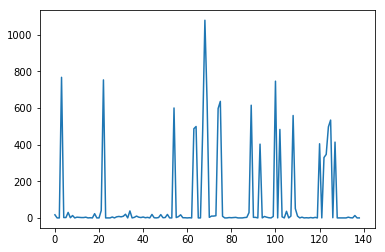

In [27]:
print(regs.count())
A = regs.prop_values('area')
plt.plot(A)

./image_features_extraction/images/bin.tif
1143


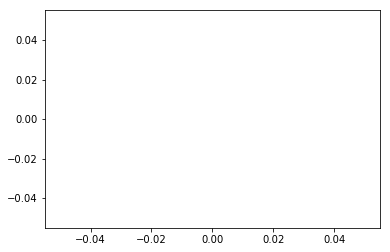

In [65]:

import image_features_extraction.Images as im

imgs = im.Images('./image_features_extraction/images')
img = imgs.item(0)
print(img.file_name())
regs = img.regions()

A = regs.prop_values('area')

print(regs.count())

plt.plot(A)

In [66]:
df = regs.get_features(['label', 'area','perimeter', 'centroid'], class_value=1)
print(df)


Empty DataFrame
Columns: [label, area, perimeter, centroid, class_name]
Index: []


In [62]:
img.regions()


In [9]:
import sys

for path in sys.path:
    print(path)

/Users/remi/Google Drive/INSIGHT PRJ/PRJ
/Users/remi/Google Drive/INSIGHT PRJ/PRJ/image_features_extraction

/Users/remi/anaconda/envs/remi_insight/lib/python35.zip
/Users/remi/anaconda/envs/remi_insight/lib/python3.5
/Users/remi/anaconda/envs/remi_insight/lib/python3.5/plat-darwin
/Users/remi/anaconda/envs/remi_insight/lib/python3.5/lib-dynload
/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages
/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg
/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/IPython/extensions
/Users/remi/.ipython


# prototyping 

In [152]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import numpy as np 
from skimage import data, io, filters


Populating the interactive namespace from numpy and matplotlib


In [ ]:
# LOAD

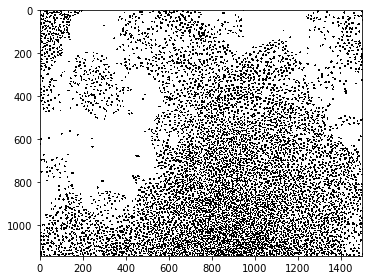

In [153]:
import scipy.misc as sm


image = sm.imread("../images/bin.tif")
#edges = filters.sobel(image)
io.imshow(image)
io.show()

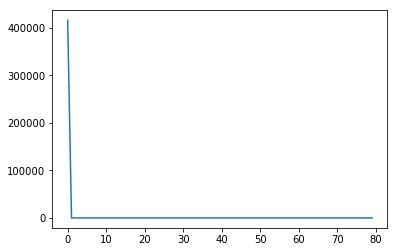

In [143]:
# HISTOGRAM

h = np.histogram(image, bins=np.arange(0, 256))
plt.plot(h[1][0:80],h[0][0:80])





In [155]:
# ithresholding to build the map

from skimage.measure import label, regionprops
import scipy.misc as sm

image = io.imread("../images/bin.tif")

val = filters.threshold_otsu(image)

mask = image > val
labels_segment = label(mask)
regions = clear_border(labels_segment)
len(regions)

a = regionprops(regions)

len(a)



5900

In [109]:
markers = np.zeros_like(image)
markers[(image >15) & (image<25)] = 1
markers[image > 150] = 2

from skimage.filters import sobel
elevation_map = sobel(image)



In [110]:
try:
    from skimage import filters
except ImportError:
    from skimage import filter as filters

from skimage.morphology import disk
from skimage import restoration

camera_sobel = filters.sobel(image)


/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):


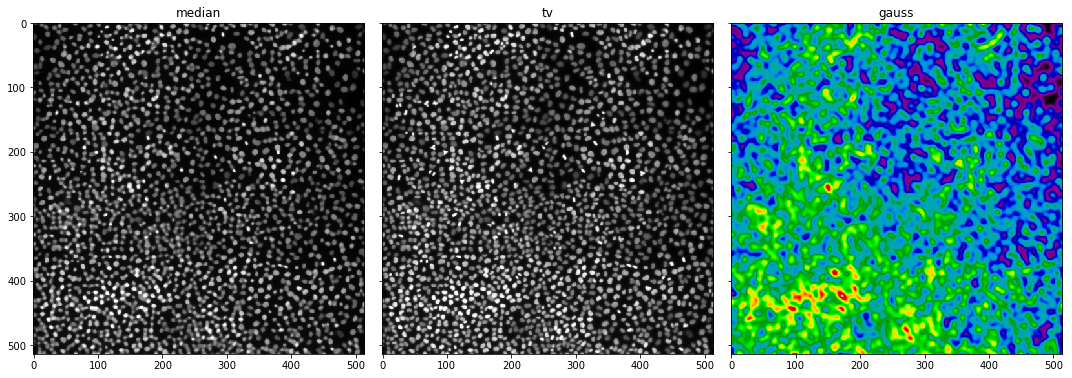

In [111]:
# FILTER

image_md = filters.rank.median(image, disk(3))
image_tv = restoration.denoise_tv_chambolle(image, weight=0.1)
image_ga = filters.gaussian_filter(image, sigma=4)

fig, axes = plt.subplots(ncols=3, figsize=(15, 15), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image_md, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('median')
ax[1].imshow(image_tv, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('tv')
ax[2].imshow(image_ga, cmap=plt.cm.spectral, interpolation='nearest')
ax[2].set_title('gauss')

fig.tight_layout()
plt.show()


79


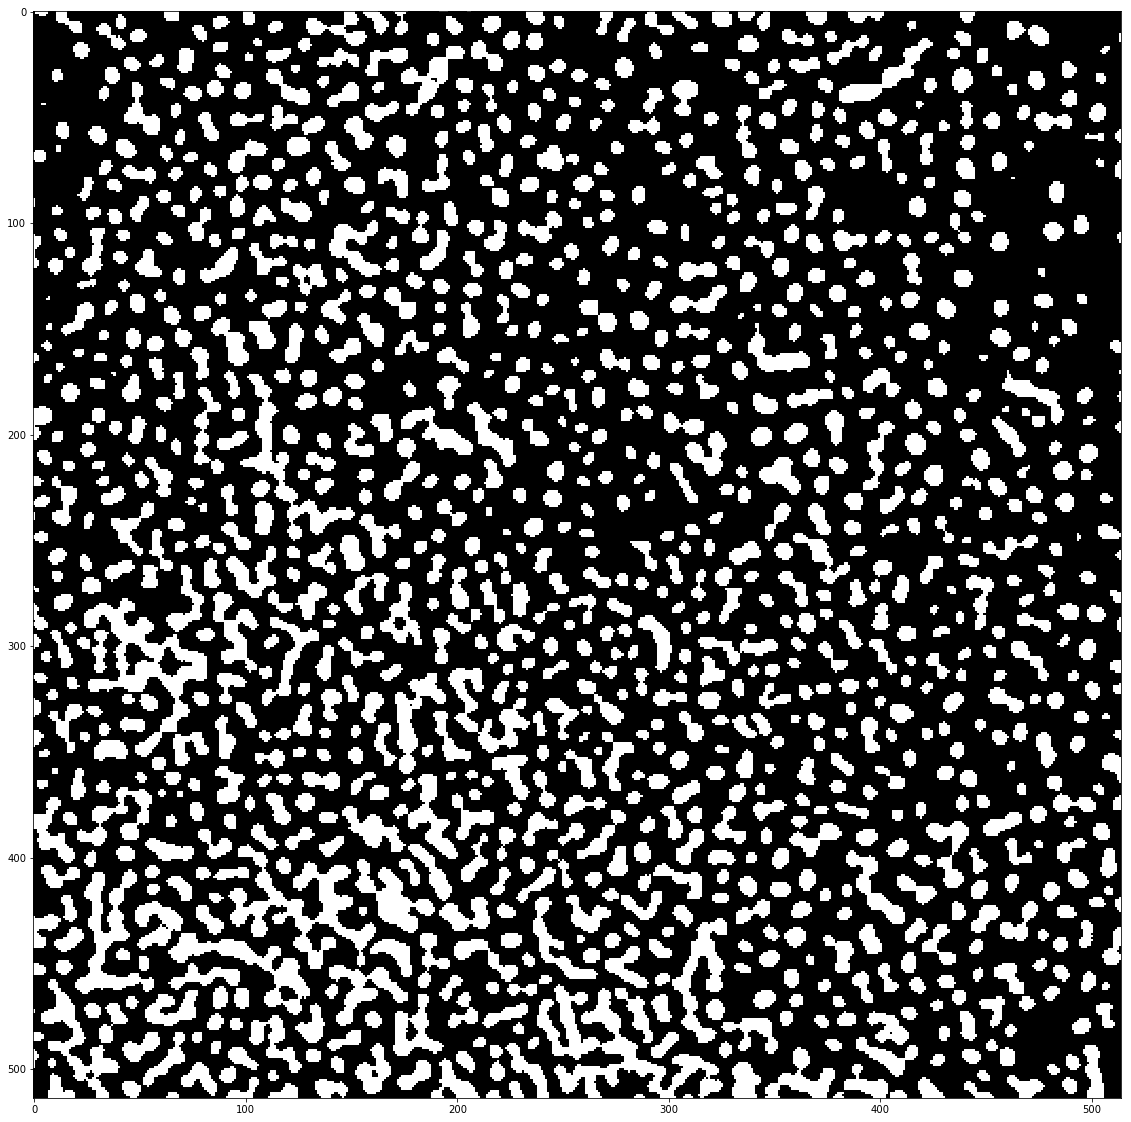

In [112]:
# THRESHOLDING 

val = filters.threshold_otsu(image_md)
mask = image_md > val

print(val)
fig, axes = plt.subplots(figsize=(20, 20), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

axes.imshow(mask, cmap=plt.cm.gray, interpolation='nearest')



/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6097: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 355 x 527)
  '(shape is %d x %d)' % inp.shape[::-1])


([array([ 337.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   18.]),
  array([ 340.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   15.]),
  array([ 339.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   16.]),
  array([ 340.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   15.]),
  array([ 341.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   14.]),
  array([ 348.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    7.]),
  array([ 350.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.]),
  array([ 350.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.]),
  array([ 351.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    4.]),
  array([ 355.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 355.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 353.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.]),
  array([ 352.,    0.,    0.

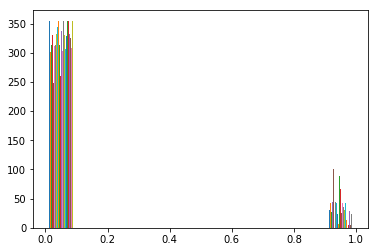

In [73]:
plt.hist(mask)

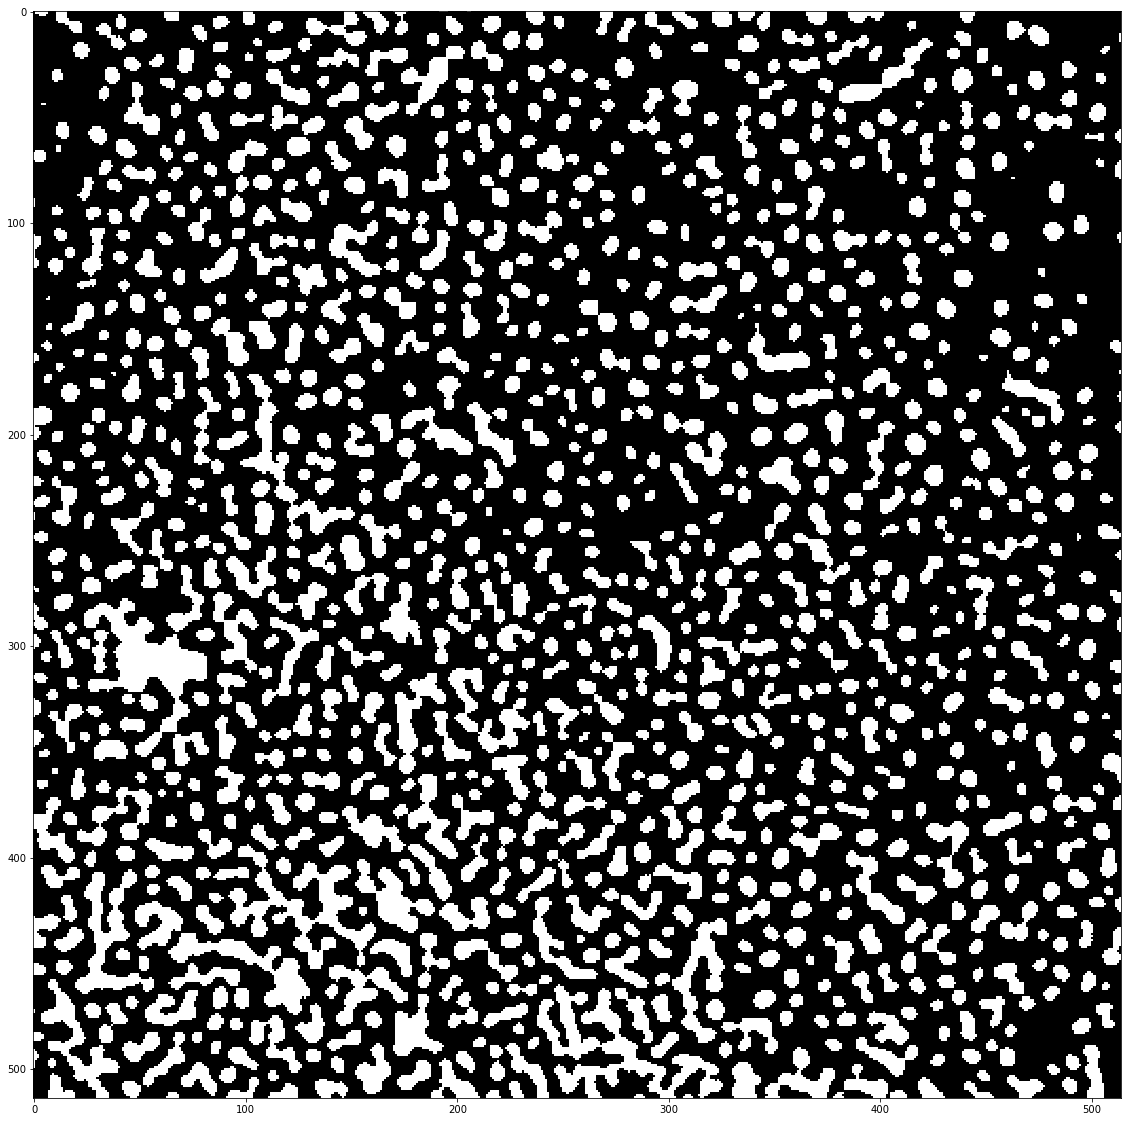

In [114]:
# FILL HOLES 

from scipy import ndimage

mask2 = ndimage.binary_opening(mask)

mask3 = ndimage.binary_closing(mask2)

mask2 = ndimage.binary_fill_holes(mask).astype(int)

fig, axes = plt.subplots(figsize=(20, 20), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

axes.imshow(mask2, cmap=plt.cm.gray, interpolation='nearest')


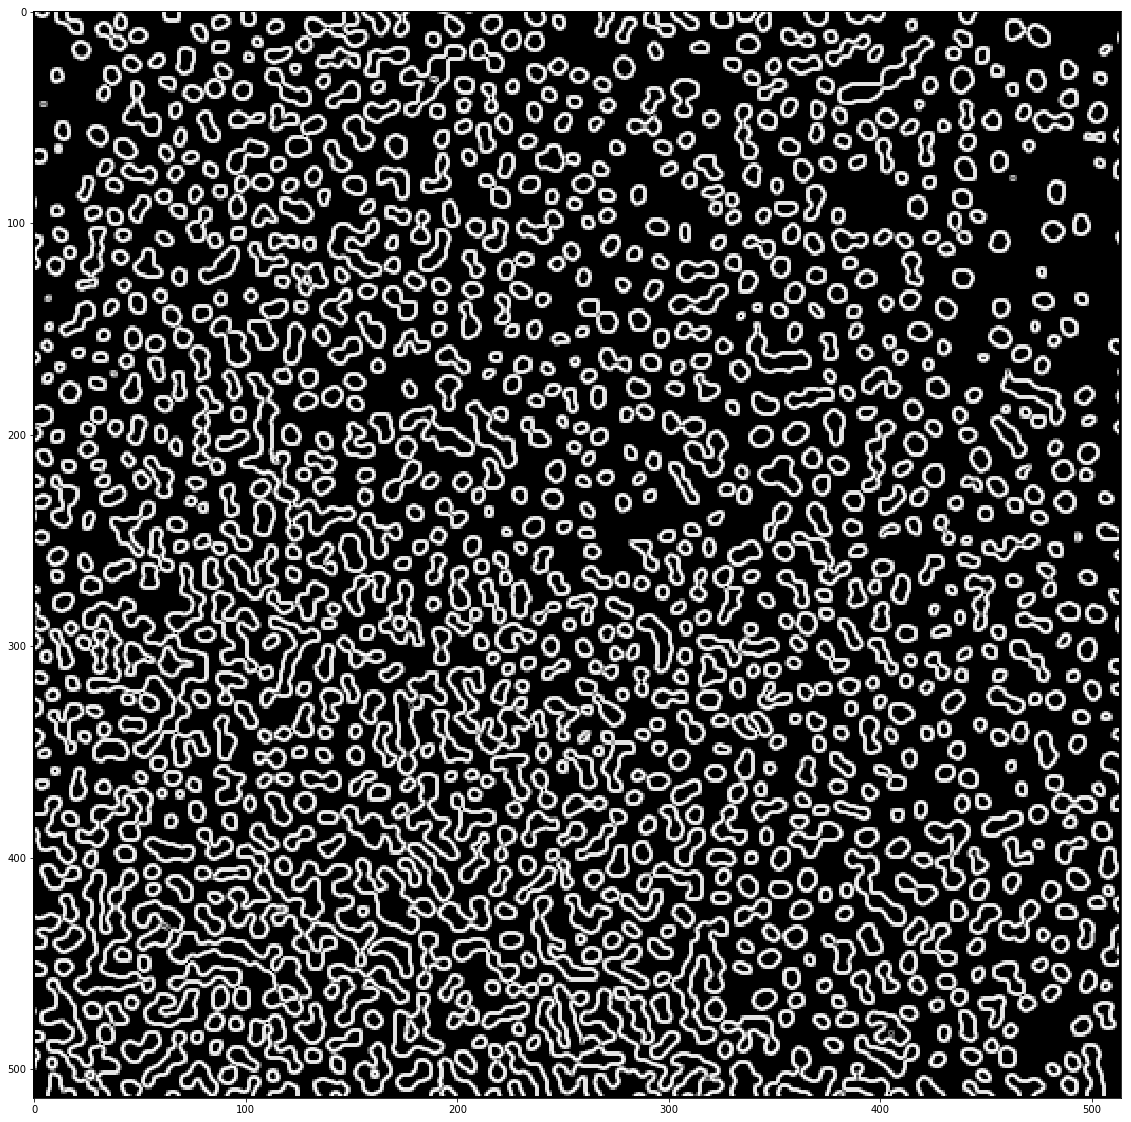

In [117]:
elevation_map = sobel(mask)


fig, axes = plt.subplots(figsize=(20, 20), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

axes.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')

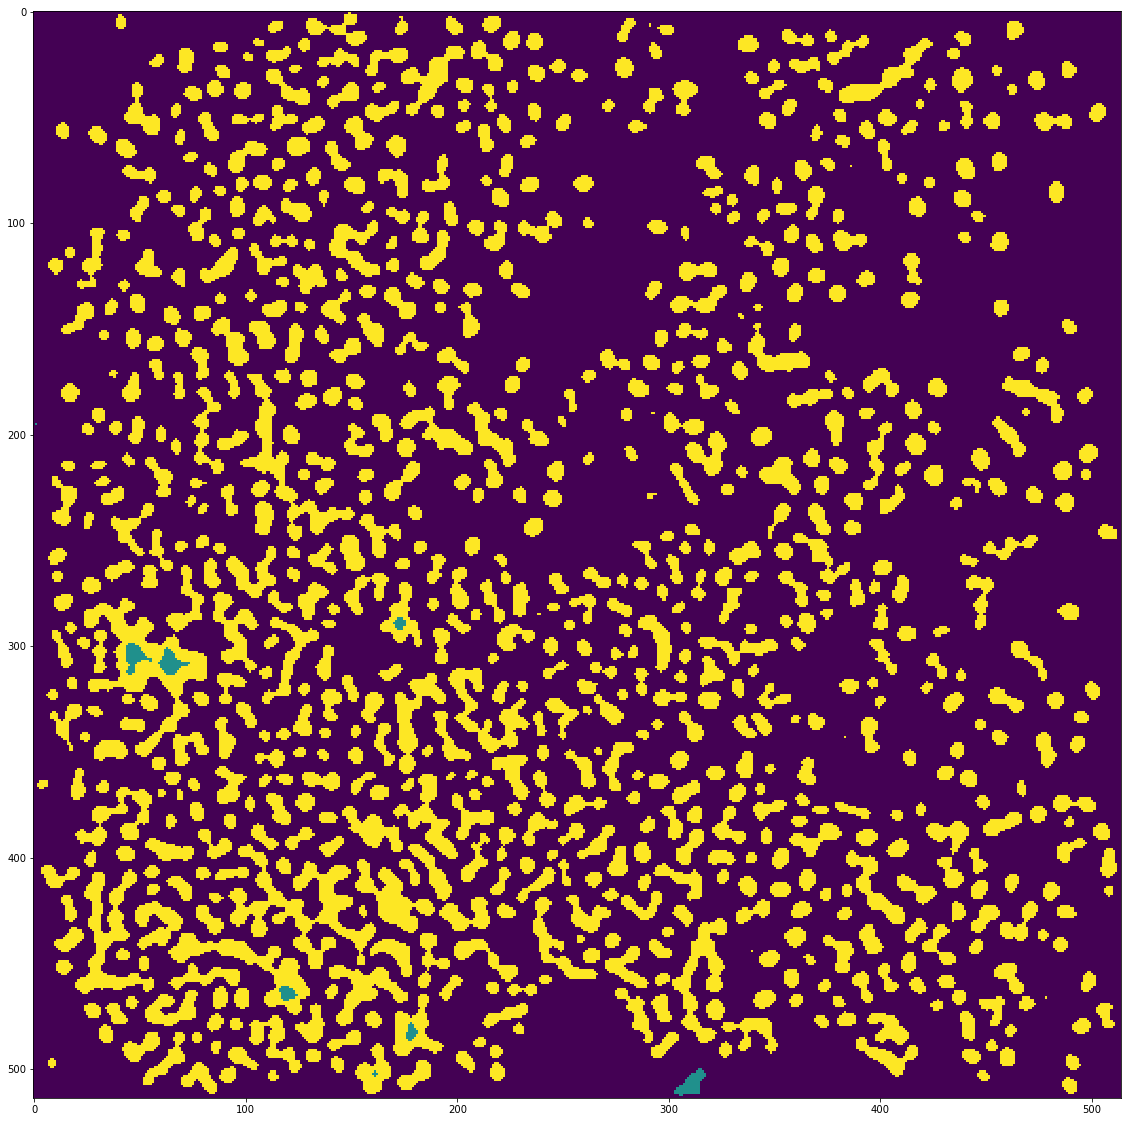

In [153]:
from skimage.segmentation import clear_border

segmentation = watershed(elevation_map, markers)
segmentation = clear_border(segmentation)


fig, axes = plt.subplots(figsize=(20, 20), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

axes.imshow(segmentation, interpolation='nearest')

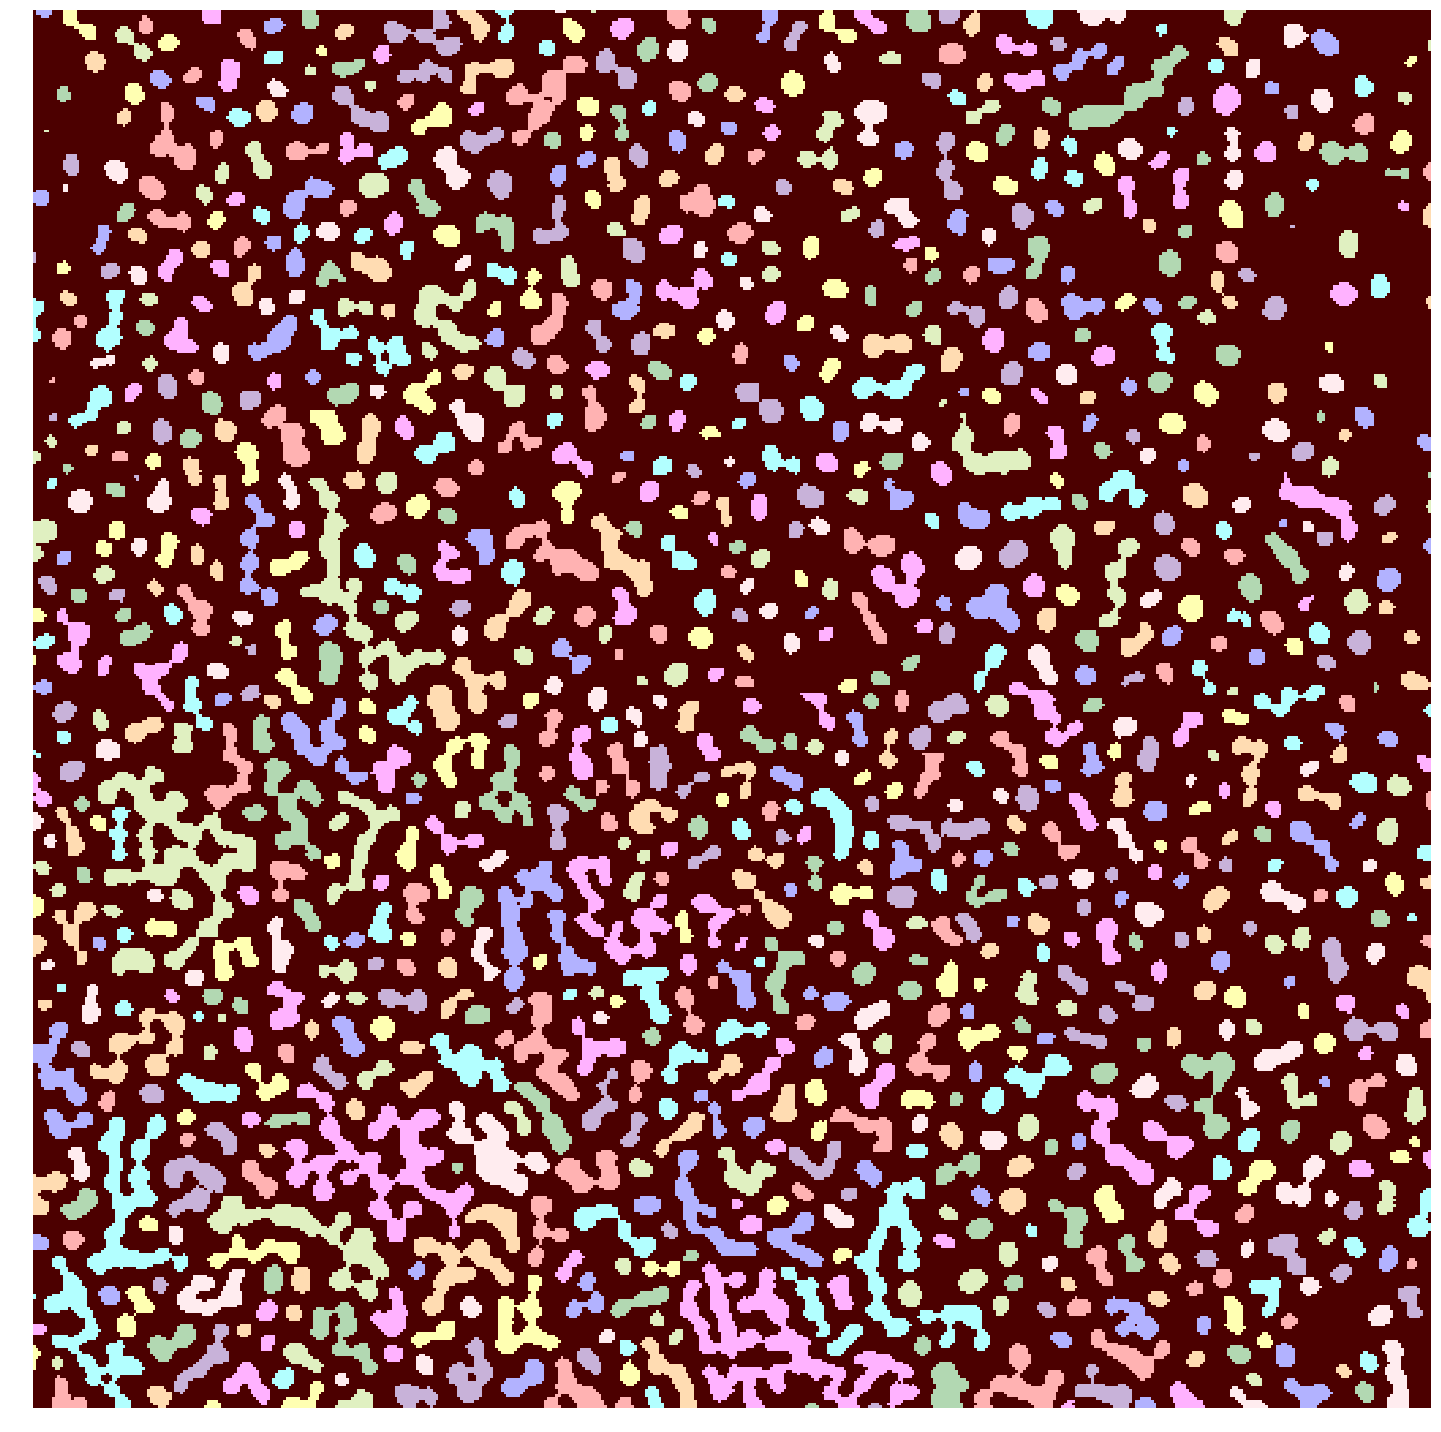

3068


In [161]:
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches

nucli_lb = label(mask)
image_label_overlay = label2rgb(nucli_lb, image=mask)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image_label_overlay)

for region in regionprops(nucli_lb):  
    areas.append(region.area)
    
    #shape = mpatches.Circle(region.weighted_centroid, radius=10, fill=True, color='blue')
    #ax.add_patch(shape)

ax.set_axis_off()
plt.tight_layout()
plt.show()

print(len(areas))


798


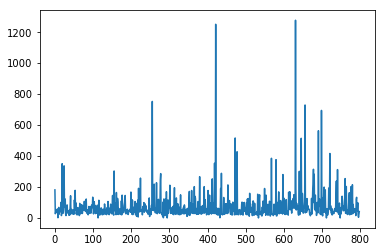

In [140]:

areas=[]
for r in regionprops(nucli_lb):
    areas.append(r.area)
    
plt.plot(areas)
print(len(areas))

In [80]:
# WATERSHED
image_ws = mask2 

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image_ws)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image_ws)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image_ws)


In [81]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

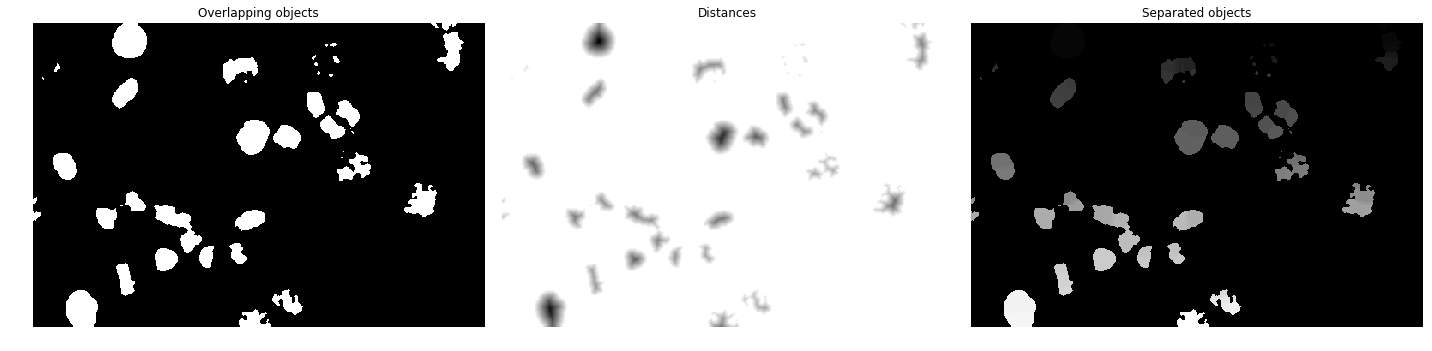

In [86]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 20), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image_ws, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [196]:
import os
from abc import ABCMeta, abstractmethod


class MyException(Exception):
    pass


class my_iterator(object):
    """
    abstract class for the object iterator to implement a collection
    """
    __metaclass__ = ABCMeta
    
    def __iterator_init__(self):
        self.current = -1
        self.__count = 0
        
        
    def item(self, i):
            pass
    
    def count_update(self, count):
        self.__count = count
        return count
    
    def count(self):
        return self.__count;
    
    # used to define the iterator: next element 
    def __iter__(self):
        return self

    
    # used to define the iterator: next element
    def __next__(self): 
        self.current += 1
        if self.current >= self.__count:
            self.current = -1
            raise StopIteration
        return self.item(self.current)
    
    
class Images2(my_iterator):
    """
    Collection of images in a given folder. 

    TODO
    and load the number of files and indexes their names for easy 
    
    read the files into the folder  
    """
        
        
    def __init__(self, folder_name, image_file_ext=['tif','tiff']): 
        self.__iterator_init__()
        
        print('rrrr')
        self.__folder_name = folder_name
        self.__image_file_ext = image_file_ext
        self.__dicfiles = []
        try:
            self.__load()
        except MyException as e:
            print(e.args)
    
    
    def __load(self):
        
        # check that the folder exists 
        
        if os.path.isdir(self.__folder_name) == False:
            raise MyException("Error: folder name does not exist")
        
        # store the file names 
        
        self.__dicfiles = []
        files = os.listdir(self.__folder_name)
        for f in files:
        
            if self.__is_imagefile(f):
                self.__dicfiles.append(f)
        
        self.count_update(len(self.__dicfiles))
        
        
    def __is_imagefile(self,file_name):
        # check the extension of the file
        
        ext0 = file_name.split(".")[-1]
        
        for ext1 in self.__image_file_ext:
            if ext1 == ext0:
                return True
            
        return False
    
    
    
    
    def item(self, i):
        """
        gets an item image
        
        :type number 
        :
        """
        try:
            if i >= self.count():
                raise MyException("error: index out of bound")
            return self.__dicfiles[i]
        except MyException as e:
            print(e.args)
    



In [197]:
O = Images2('./images')

O.count()

rrrr


7

In [198]:
for i in O:
    print(i)

img1 copy 2.tiff
img1 copy 3.tiff
img1 copy 4.tiff
img1 copy.tiff
img1.tiff
nucl1.tif
nucl2.tif


# test the save function

In [1]:
import image_features_extraction.Images as fe

imgs = fe.Images('../images')

collection_regions = imgs.item(0).regions()
print('Num regions: {}'.format(collection_regions.count()))




Num regions: 5900


In [4]:
features = collection_regions.get_features(['label', 'area','perimeter'], class_value=1)
features.get_dataframe().head()

,label,area,perimeter,class_name
0,22,64,28.278175,1
1,23,86,33.556349,1
2,24,100,35.556349,1
3,25,50,24.142136,1
4,26,80,31.556349,1


In [5]:

features.save('./test_file2.csv')
        
        

1

,label,area,perimeter,class_name
0,22,64,28.278175,5
1,23,86,33.556349,5
2,24,100,35.556349,5
3,25,50,24.142136,5
4,26,80,31.556349,5


one or more input labels might be wrong:name '_Features__save_file' is not defined


0

In [ ]:
file_name = 'a/test_save.csv'

with open(file_name,'w') as f:
        df.to_csv(f, header=False)

In [10]:
import pytest as pt

pytest

<module 'pytest' from '/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/pytest.py'>